# Online Retail Dataset: RFM Scores
In this notebook, I'll use the customer data to compute the RFM scores.
## Imports

In [1]:
from pathlib import Path
from typing import Literal, cast, get_args

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from pandas.testing import assert_frame_equal, assert_index_equal, assert_series_equal

from utils.rfm import RFMAttribute, add_rfm_scores

## Read customer data

In [2]:
# Path to dataset
file_path = Path.cwd().parents[1] / "data" / "online_retail.csv"
assert file_path.exists(), f"file doesn't exist: {file_path}"

In [3]:
df = pd.read_csv(
    file_path,
    dtype={
        "InvoiceNo": "category",
        "CustomerID": "category",
        "TotalPrice": np.float_,
    },
    parse_dates=["InvoiceDate"],
)
df.head(15)

,InvoiceNo,InvoiceDate,CustomerID,TotalPrice
0,536365,2010-12-01,17850,139.12
1,536366,2010-12-01,17850,22.20
2,536367,2010-12-01,13047,278.73
3,536368,2010-12-01,13047,70.05
4,536369,2010-12-01,13047,17.85
5,536370,2010-12-01,12583,855.86
6,536371,2010-12-01,13748,204.00
7,536372,2010-12-01,17850,22.20
8,536373,2010-12-01,17850,259.86
9,536374,2010-12-01,15100,350.40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18532 entries, 0 to 18531
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    18532 non-null  category      
 1   InvoiceDate  18532 non-null  datetime64[ns]
 2   CustomerID   18532 non-null  category      
 3   TotalPrice   18532 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 669.8 KB


In [5]:
# This may seem redundant, but it allows this code to be reused later
def read_customer_data(file_path: Path) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        dtype={
            "InvoiceNo": "category",
            "CustomerID": "category",
            "TotalPrice": np.float_,
        },
        parse_dates=["InvoiceDate"],
    )

## Compute RFM attributes
### Recency
**To calculate the recency, I'll pretend that I'm performing this analysis 1
day after the last piece of data was collected.**

In [6]:
today = df["InvoiceDate"].max() + pd.Timedelta(days=1)
today

Timestamp('2011-12-10 00:00:00')

Recall that, in this case, recency corresponds to the number of days since
the last purchase. Figuring out the best way to compute this metric:

In [7]:
# Recency for a particular customer
(today - df.loc[df["CustomerID"] == "14688", "InvoiceDate"].max()).days

8

In [8]:
# Recency for all customers
recency = (today - df.groupby(by="CustomerID", observed=True).InvoiceDate.max()).dt.days.rename("Recency")
recency = cast(pd.Series, recency)
recency.head()

CustomerID
12346    326
12347      3
12348     76
12349     19
12350    311
Name: Recency, dtype: int64

In [9]:
recency.loc["14688"]

8

This seems OK. Then I'll start building the DataFrame that will store the RFM
scores:

In [10]:
df_rfm = (
    df.groupby(by="CustomerID", observed=True)
    .agg(LastPurchaseDate=pd.NamedAgg(column="InvoiceDate", aggfunc="max"))
    .assign(Recency=lambda x: (today - x.LastPurchaseDate).dt.days)
    .drop(columns="LastPurchaseDate")
)
df_rfm.head(15)

,Recency
CustomerID,
12346,326
12347,3
12348,76
12349,19
12350,311
12352,37
12353,205
12354,233
12355,215


### Frequency
Here I'll use the following definition of frequency: for a given customer,
frequency is the total number of purchases he/she made. Figuring out the best
way to evaluate this metric:

In [11]:
# Frequency for a particular customer
df[df["CustomerID"] == "14688"].shape[0]

21

In [12]:
# Alternative solution
df.loc[df["CustomerID"] == "14688", "InvoiceNo"].nunique()

21

In [13]:
# Frequency for all customers
freq_1 = df.groupby(by="CustomerID", observed=True).InvoiceNo.count().rename("Frequency")
freq_1 = cast(pd.Series, freq_1)
freq_1.head()

CustomerID
12346    1
12347    7
12348    4
12349    1
12350    1
Name: Frequency, dtype: int64

In [14]:
freq_1.loc["14688"]

21

In [15]:
# Alternative solution
freq_2 = df.groupby(by="CustomerID", observed=True).InvoiceNo.nunique().rename("Frequency")
freq_2 = cast(pd.Series, freq_2)
freq_2.head()

CustomerID
12346    1
12347    7
12348    4
12349    1
12350    1
Name: Frequency, dtype: int64

In [16]:
assert_series_equal(freq_1, freq_2)

The two methods used above are equivalent. Then I'll calculate the frequency
with the aid of the simplest one:

In [17]:
assert_index_equal(df_rfm.index, freq_1.index)

In [18]:
df_rfm["Frequency"] = df.groupby(by="CustomerID", observed=True).InvoiceNo.count()
df_rfm.head(15)

,Recency,Frequency
CustomerID,,
12346,326,1
12347,3,7
12348,76,4
12349,19,1
12350,311,1
12352,37,8
12353,205,1
12354,233,1
12355,215,1


### Monetary
Here I'll use the following definition of monetary (value): for a given
customer, monetary corresponds to the total amount spent by him/her. Figuring
out the best way to evaluate this quantity:

In [19]:
# Monetary for a particular customer
df.loc[df["CustomerID"] == "14688", "TotalPrice"].sum()

5630.87

In [20]:
# Monetary for all customers
monetary = df.groupby(by="CustomerID", observed=True).TotalPrice.sum().rename("Monetary")
monetary = cast(pd.Series, monetary)
monetary.head()

CustomerID
12346    77183.60
12347     4310.00
12348     1797.24
12349     1757.55
12350      334.40
Name: Monetary, dtype: float64

In [21]:
monetary.loc["14688"]

5630.87

Now that I understand how to perform the desired calculation, I'll add
monetary to my DataFrame:

In [22]:
assert_index_equal(df_rfm.index, monetary.index)

In [23]:
df_rfm["Monetary"] = df.groupby(by="CustomerID", observed=True).TotalPrice.sum()
df_rfm.head(15)

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40
12352,37,8,2506.04
12353,205,1,89.00
12354,233,1,1079.40
12355,215,1,459.40


In [24]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 273.1 KB


In [25]:
# Quick consistency checks
assert (df_rfm["Recency"] > 0).all()
assert (df_rfm["Frequency"] > 0).all()
assert (df_rfm["Monetary"] > 0.0).all()

At this point, all RFM attributes have been evaluated. Before proceeding,
let's collect the essential parts of the above code, and transform them into
a function:

In [26]:
def compute_rfm_attributes(df: pd.DataFrame) -> pd.DataFrame:
    today = df.InvoiceDate.max() + pd.Timedelta(days=1)
    customer_groups = df.groupby(by="CustomerID", observed=True)
    return (
        customer_groups.agg(LastPurchaseDate=pd.NamedAgg(column="InvoiceDate", aggfunc="max"))
        .assign(
            Recency=lambda x: (today - x.LastPurchaseDate).dt.days,
            Frequency=customer_groups.InvoiceNo.count(),
            Monetary=customer_groups.TotalPrice.sum(),
        )
        .drop(columns="LastPurchaseDate")
    )

In [27]:
# Quick tests
customer_data = read_customer_data(file_path)
assert_frame_equal(customer_data, df)

In [28]:
rfm_attrs = compute_rfm_attributes(customer_data)
assert_frame_equal(rfm_attrs, df_rfm)

In [29]:
del customer_data
del rfm_attrs

## Visualizing RFM attributes
### Boxplots

In [30]:
RFM_UNITS = {
    "Recency": "days",
    "Frequency": "purchases",
    "Monetary": "£",
}


def boxplot_rfm(
    df: pd.DataFrame,
    attr: RFMAttribute,
    figsize: tuple[float, float] = (6.0, 6.0),
) -> None:
    fig = plt.figure(figsize=figsize, layout="tight")
    ax = fig.add_subplot()
    ax.boxplot(df[attr])
    ax.set_title(f"Boxplot of {attr}")
    ax.set_xticks([])
    ax.set_ylabel(f"{attr} ({RFM_UNITS[attr]})")
    ax.set_ylim(bottom=0)
    plt.show()

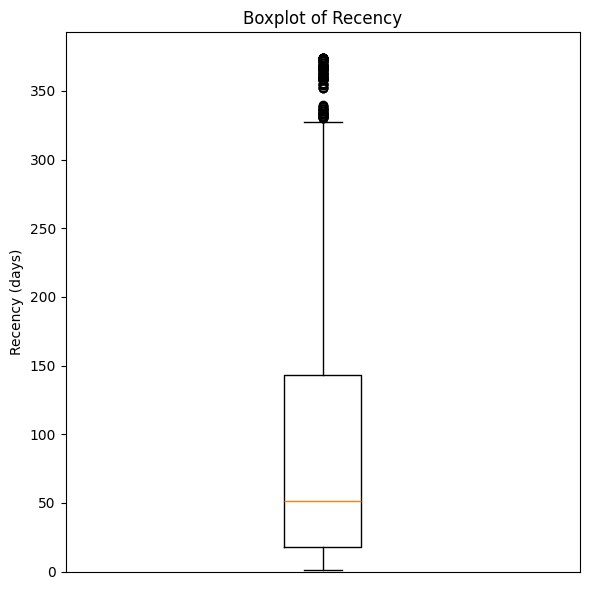

In [31]:
# Recency
boxplot_rfm(df_rfm, "Recency")

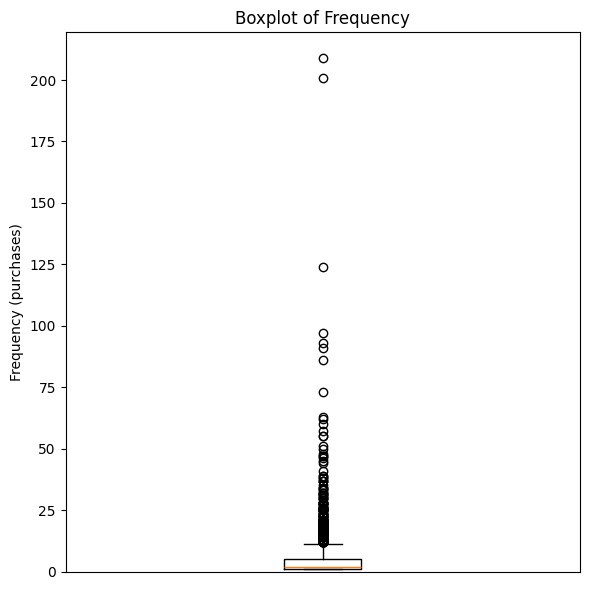

In [32]:
# Frequency
boxplot_rfm(df_rfm, "Frequency")

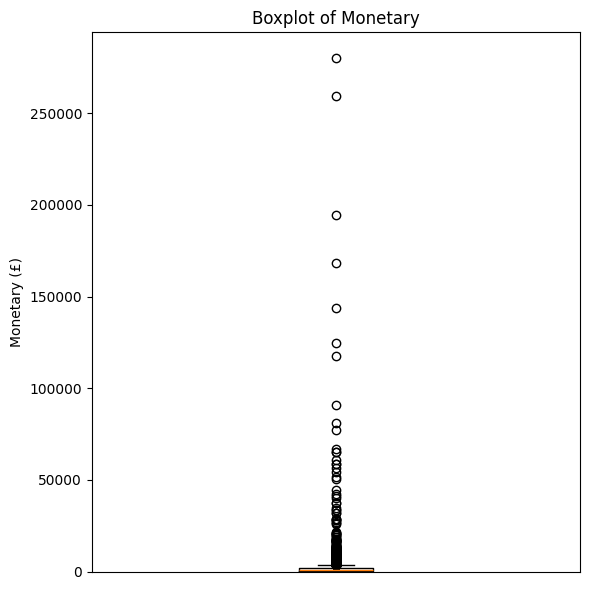

In [33]:
# Monetary
boxplot_rfm(df_rfm, "Monetary")

Clearly, all RFM attributes have outliers. But the situation is "worse" for
`Frequency` and `Monetary`. There may be an explanation for this. Some of the
online retailer's customers are wholesale stores. It's reasonable to assume
that such customers make purchases very frequently, and spend a good amount
of money. This explains at least a portion of the outliers for `Frequency`
and `Monetary`.
### KDE plots

In [34]:
def kde_rfm(
    df: pd.DataFrame,
    attr: RFMAttribute,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    fig = plt.figure(figsize=figsize, layout="tight")
    ax = fig.add_subplot()
    sns.kdeplot(data=df, x=attr, ax=ax)
    ax.set_title(f"KDE for {attr}")
    ax.set_xlabel(f"{attr} ({RFM_UNITS[attr]})")
    plt.show()

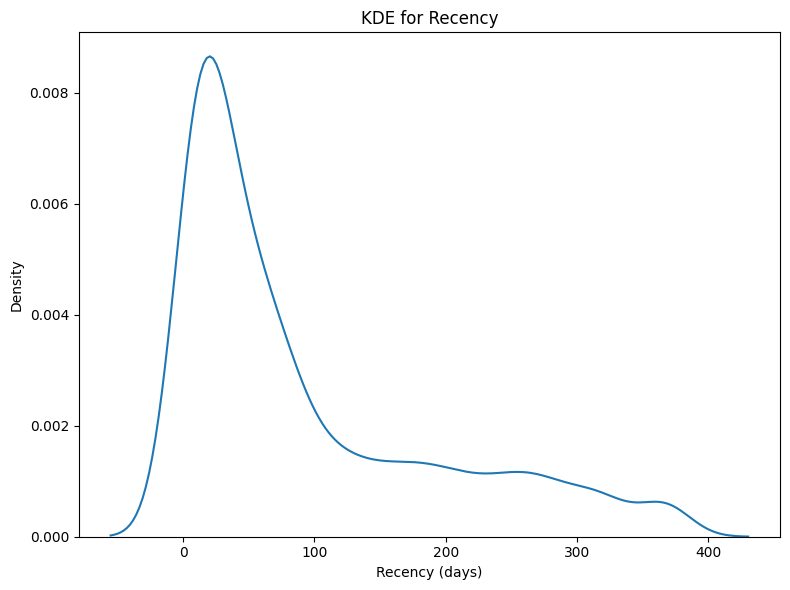

In [35]:
# Recency
kde_rfm(df_rfm, "Recency")

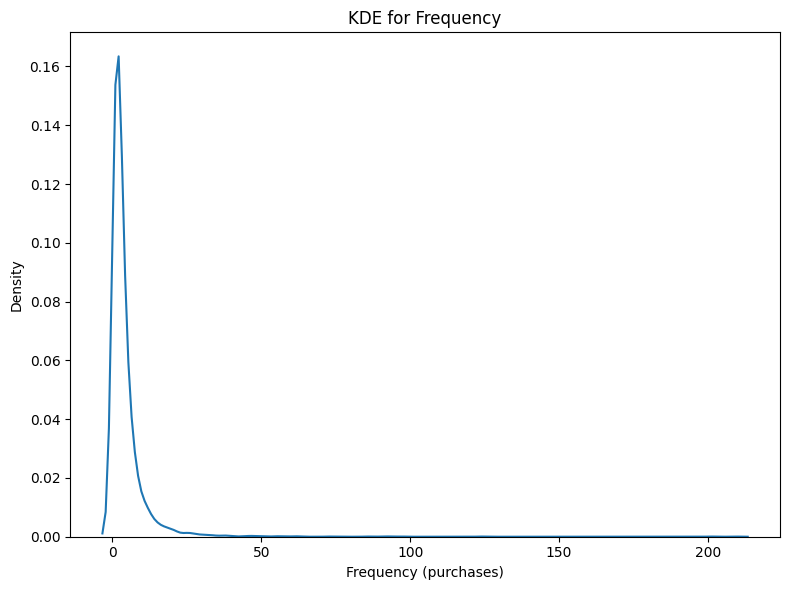

In [36]:
# Frequency
kde_rfm(df_rfm, "Frequency")

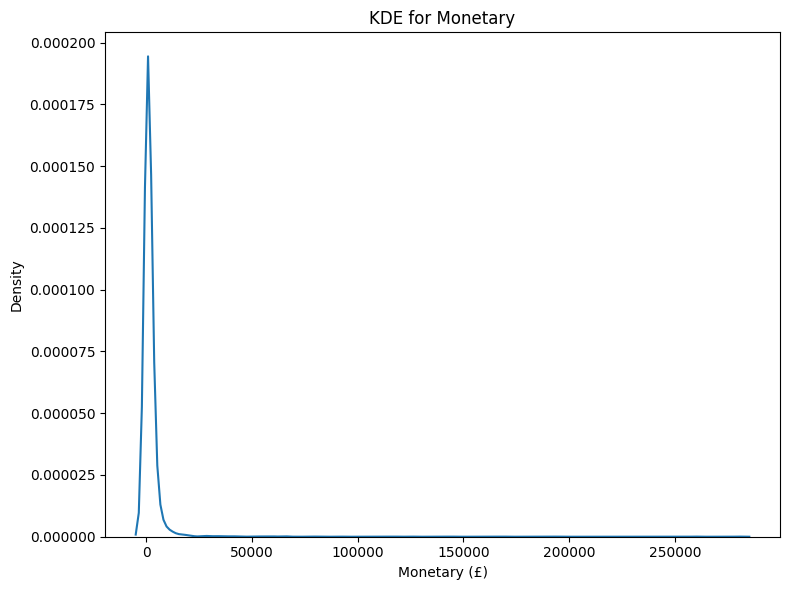

In [37]:
# Monetary
kde_rfm(df_rfm, "Monetary")

### Correlation

In [38]:
def correlation_heatmap(
    df: pd.DataFrame,
    columns: list[str] = ["Recency", "Frequency", "Monetary"],
    figsize: tuple[float, float] = (6.0, 6.0),
) -> None:
    fig = plt.figure(figsize=figsize, layout="tight")
    ax = fig.add_subplot()
    sns.heatmap(df[columns].corr(), annot=True, cmap=mpl.colormaps["coolwarm"], ax=ax)
    ax.set_title("Heatmap of Correlations")
    plt.show()

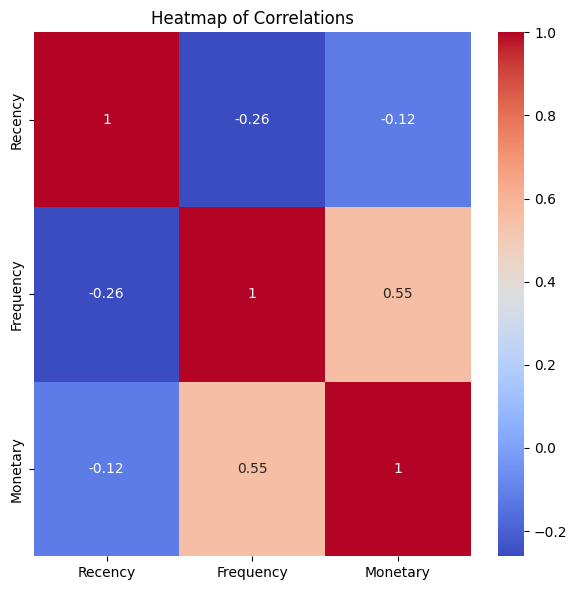

In [39]:
# Correlation between RFM attributes
correlation_heatmap(df_rfm)

## Dealing with outliers
Later, I'll use the RFM attributes to do customer segmentation with the aid
of clustering algorithms. In these cases, the presence of outliers in the
dataset may lead to poor results. For this reason, I'll implement a few
functions for removing outliers.

I won't use these functions right away. Except for testing. I'm including
them here for the sake of organization. It makes sense to add the code for
removing outliers after the one for computing the features.
### IQR method
To remove outliers, I'll use the interquartile range (IQR) method. A very
simple explanation of this method can be found
[here](https://online.stat.psu.edu/stat200/lesson/3/3.2). It's important to
note that, when we adopt this approach, the notion of an outlier is the same
as when creating a boxplot. So I'm going to remove the same outliers that
were shown above.

Figuring out the best way to do this:

In [40]:
# Compute quartiles and bounds
cols = ["Frequency", "Monetary"]  # just an example
quartiles_and_bounds = (
    pd.concat(
        [
            df_rfm[cols].quantile(q=0.25).rename("Q1"),
            df_rfm[cols].quantile(q=0.75).rename("Q3"),
        ],
        axis=1,
    )
    .assign(
        IQR=lambda x: x.Q3 - x.Q1,
        LowerBound=lambda x: x.Q1 - 1.5 * x.IQR,
        UpperBound=lambda x: x.Q3 + 1.5 * x.IQR,
    )
    .transpose()
)
quartiles_and_bounds

,Frequency,Monetary
Q1,1.0,307.4150
Q3,5.0,1661.7400
IQR,4.0,1354.3250
LowerBound,-5.0,-1724.0725
UpperBound,11.0,3693.2275


In [41]:
bounds = quartiles_and_bounds.loc[["LowerBound", "UpperBound"], :]
bounds

,Frequency,Monetary
LowerBound,-5.0,-1724.0725
UpperBound,11.0,3693.2275


In [42]:
# Select indexes I want to KEEP
idxs = df_rfm.index

for col in cols:
    mask_lower = df_rfm[col] < bounds.loc["LowerBound", col]
    idxs = idxs.drop(df_rfm[mask_lower].index, errors="ignore")

    mask_upper = df_rfm[col] > bounds.loc["UpperBound", col]
    idxs = idxs.drop(df_rfm[mask_upper].index, errors="ignore")

In [43]:
# Remove outliers
df_no_out = df_rfm.loc[idxs, :]

Check by recreating the boxplots:

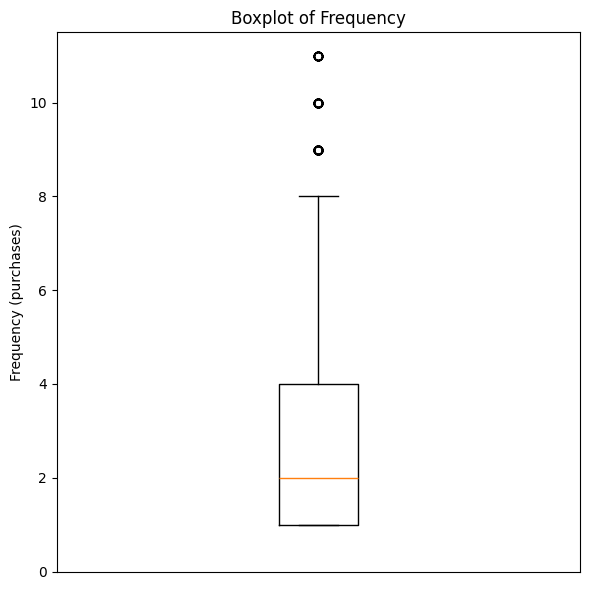

In [44]:
# Frequency
boxplot_rfm(df_no_out, "Frequency")

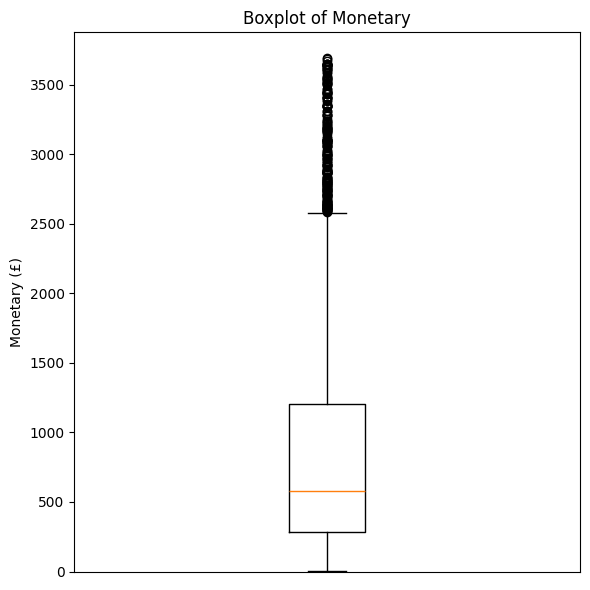

In [45]:
# Monetary
boxplot_rfm(df_no_out, "Monetary")

Using the above code to define a couple of functions that allow us to remove
outliers:

In [46]:
def compute_outlier_bounds(df: pd.DataFrame, columns: str | list[str], scale: float = 1.5) -> pd.DataFrame:
    if isinstance(columns, str):
        columns = [columns]
    return (
        pd.concat(
            [
                df[columns].quantile(q=0.25).rename("Q1"),
                df[columns].quantile(q=0.75).rename("Q3"),
            ],
            axis=1,
        )
        .assign(
            IQR=lambda x: x.Q3 - x.Q1,
            LowerBound=lambda x: x.Q1 - scale * x.IQR,
            UpperBound=lambda x: x.Q3 + scale * x.IQR,
        )
        .transpose()
        .loc[["LowerBound", "UpperBound"], :]
    )

In [47]:
def remove_outliers(df: pd.DataFrame, columns: str | list[str], scale: float = 1.5) -> pd.DataFrame:
    bounds = compute_outlier_bounds(df, columns, scale)
    idxs = df.index

    if isinstance(columns, str):
        columns = [columns]

    for column in columns:
        mask_lower = df[column] < bounds.loc["LowerBound", column]
        idxs = idxs.drop(df[mask_lower].index, errors="ignore")

        mask_upper = df[column] > bounds.loc["UpperBound", column]
        idxs = idxs.drop(df[mask_upper].index, errors="ignore")

    return df.loc[idxs, :]

In [48]:
# At this point, this step isn't necessary. This command is here just for
# testing.

# Remove outliers from `Frequency` and `Monetary`
df_func = remove_outliers(df_rfm, columns=["Frequency", "Monetary"])

In [49]:
assert_frame_equal(df_func, df_no_out)
del df_func

## Compute RFM scores
Finally, it's time to compute the RFM scores. To do so, I'll use the
`add_rfm_scores` function that I defined in the `utils` package:

In [50]:
df_rfm = add_rfm_scores(df_rfm)
df_rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,"1,1,5",2.333333
12347,3,7,4310.00,5,5,5,"5,5,5",5.000000
12348,76,4,1797.24,2,4,4,"2,4,4",3.333333
12349,19,1,1757.55,4,1,4,"4,1,4",3.000000
12350,311,1,334.40,1,1,2,"1,1,2",1.333333


In [51]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4338 non-null   int64   
 1   Frequency  4338 non-null   int64   
 2   Monetary   4338 non-null   float64 
 3   RScore     4338 non-null   category
 4   FScore     4338 non-null   category
 5   MScore     4338 non-null   category
 6   RFMCell    4338 non-null   object  
 7   RFMScore   4338 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 435.2+ KB


## Save computed scores

In [52]:
# Path to output CSV
out_file = file_path.parent / "rfm_scores_5.csv"

df_rfm.to_csv(out_file)

## Visualization
### Recency and R score
Check that every bin contains approximately the same number of customers:

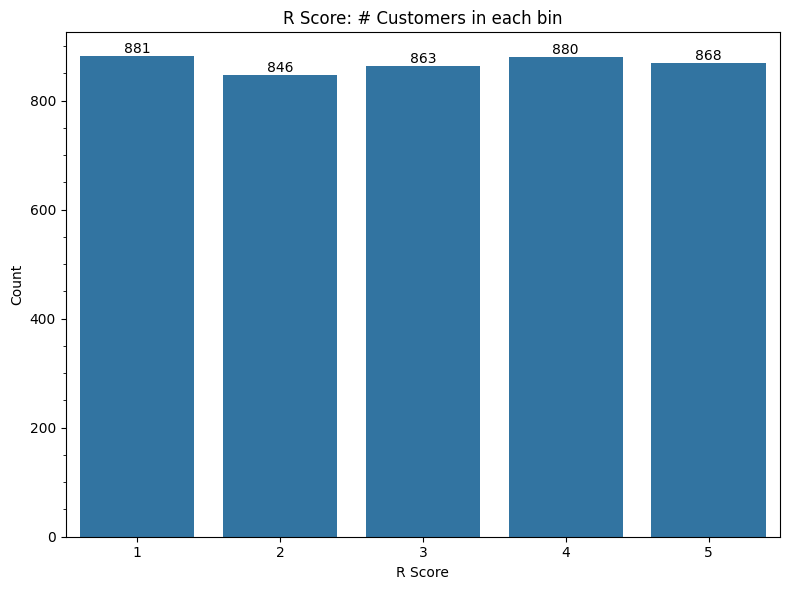

In [53]:
fig = plt.figure(figsize=(8.0, 6.0), layout="tight")
ax = fig.add_subplot()
sns.countplot(data=df_rfm, x="RScore", ax=ax)
ax.bar_label(ax.containers[0])  # pyright: ignore [reportArgumentType]
ax.set_title("R Score: # Customers in each bin")
ax.set_xlabel("R Score")
ax.set_ylabel("Count")
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

Distribution of `Recency` for each R score:

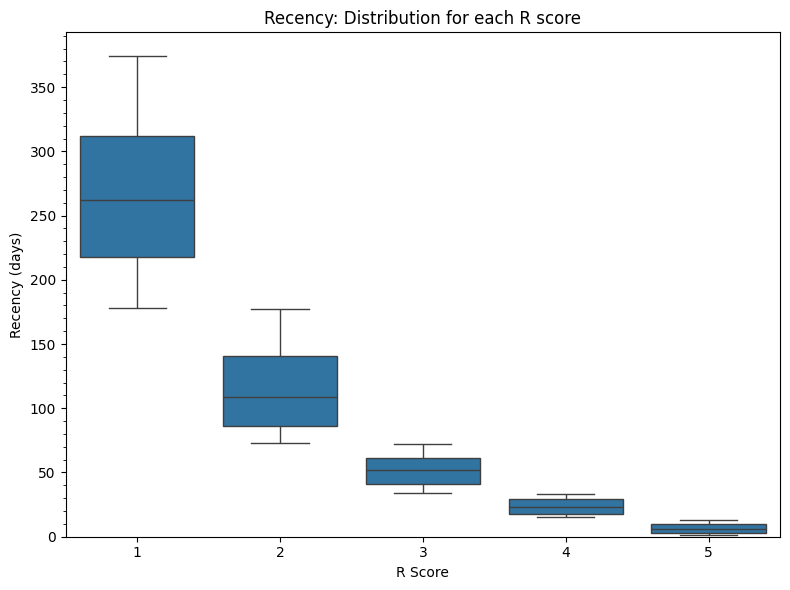

In [54]:
fig = plt.figure(figsize=(8.0, 6.0), layout="tight")
ax = fig.add_subplot()
sns.boxplot(data=df_rfm, x="RScore", y="Recency", ax=ax)
ax.set_title("Recency: Distribution for each R score")
ax.set_xlabel("R Score")
ax.set_ylabel("Recency (days)")
ax.set_ylim(bottom=0)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.show()

In [55]:
# Quick check
df_rfm.loc[df_rfm["RScore"] == 1, "Recency"].describe()

count    881.000000
mean     267.472191
std       57.888721
min      178.000000
25%      218.000000
50%      262.000000
75%      312.000000
max      374.000000
Name: Recency, dtype: float64

### Frequency and F score
Next, we're going to do something very similar to what we've done above. Then
it's convenient to use this code to define a couple of functions:

In [56]:
# Path to images directory
IMG_DIR = Path.cwd().parents[1] / "img"
assert IMG_DIR.exists(), f"directory doesn't exist: {IMG_DIR}"

In [57]:
def plot_bin_count(
    df: pd.DataFrame,
    score: Literal["R", "F", "M"],
    *,
    save: bool = False,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    fig = plt.figure(figsize=figsize, layout="tight")
    ax = fig.add_subplot()

    sns.countplot(data=df, x=f"{score}Score", ax=ax)
    ax.bar_label(ax.containers[0])  # pyright: ignore [reportArgumentType]

    ax.set_title(f"{score} Score: # Customers in each bin")
    ax.set_xlabel(f"{score} Score")
    ax.set_ylabel("Count")

    if save:
        out_img = IMG_DIR / f"bin_count_{score.lower()}score.png"
        fig.savefig(out_img)
        plt.close(fig)
    else:
        plt.show()

In [58]:
def plot_distribution_by_score(
    df: pd.DataFrame,
    attr: RFMAttribute,
    *,
    save: bool = False,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    fig = plt.figure(figsize=figsize, layout="tight")
    ax = fig.add_subplot()

    first_letter = attr[0]
    sns.boxplot(
        data=df,
        x=f"{first_letter}Score",
        y=attr,
        ax=ax,
        # I just want to know if the RFM attributes are distributed in a way
        # that makes sense. For this reason, I'll hide the outliers.
        showfliers=False,
    )

    ax.set_title(f"{attr}: Distribution for each {first_letter} score")
    ax.set_xlabel(f"{first_letter} Score")
    ax.set_ylabel(f"{attr} ({RFM_UNITS[attr]})")
    ax.set_ylim(bottom=0)

    if save:
        out_img = IMG_DIR / f"{attr.lower()}_distribution.png"
        fig.savefig(out_img)
        plt.close(fig)
    else:
        plt.show()

Using these functions to generate the desired plots:

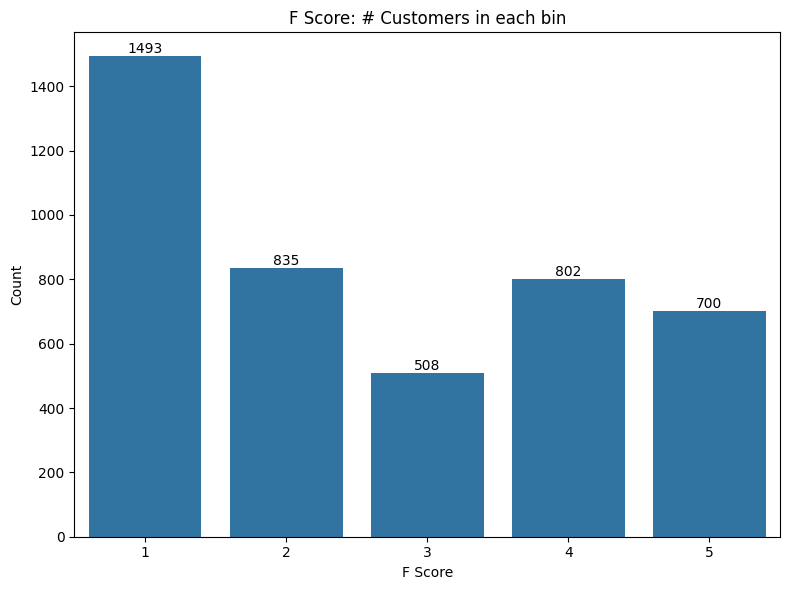

In [59]:
plot_bin_count(df_rfm, "F")

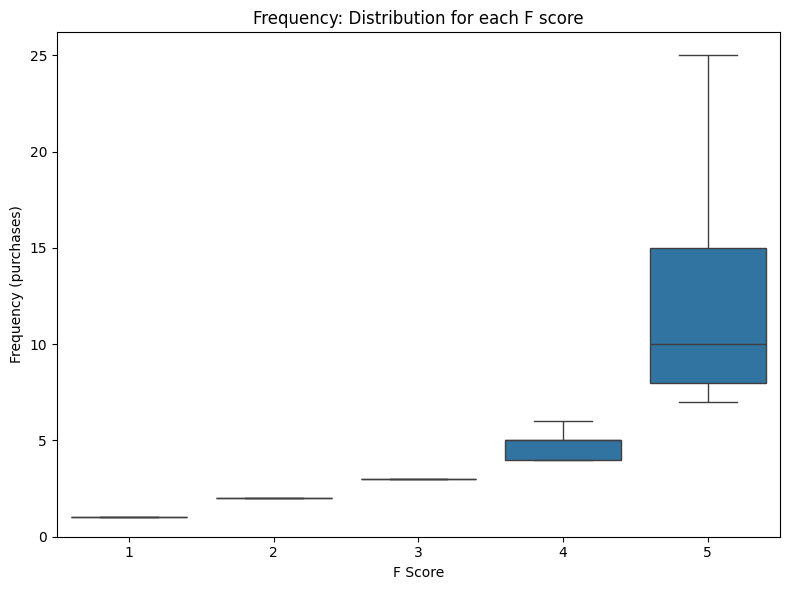

In [60]:
plot_distribution_by_score(df_rfm, "Frequency")

In the case of the F score, the number of customers in each bin varies
considerably. Basically, this imbalance is a consequence of the following
fact: **more than a third of customers only made a single purchase**. This
fact can be verified as follows:

In [61]:
df_rfm.Frequency.transform(lambda f: "1 purchase" if f == 1 else "2 or more purchases").value_counts(
    normalize=True, sort=False
).mul(100.0).transform(lambda p: f"{p:.2f}%").sort_index()

Frequency
1 purchase             34.42%
2 or more purchases    65.58%
Name: proportion, dtype: object

In fact, all customers who purchased only once were assigned an F score of 1:

In [62]:
df_rfm.loc[df_rfm.FScore == 1, "Frequency"].unique()

array([1])

Something similar happened for F scores 2 and 3:

In [63]:
df_rfm.loc[df_rfm.FScore == 2, "Frequency"].unique()

array([2])

In [64]:
df_rfm.loc[df_rfm.FScore == 3, "Frequency"].unique()

array([3])

This is the reason why we see no variation in the first 3 boxplots above.

The `FScore = 4` case is the first that corresponds to more than one
`Frequency` value:

In [65]:
df_rfm.loc[df_rfm.FScore == 4, "Frequency"].value_counts()

Frequency
4    388
5    242
6    172
Name: count, dtype: int64

When `FScore = 5`, there's a lot more variation:

In [66]:
np.sort(df_rfm.loc[df_rfm.FScore == 5, "Frequency"].unique())

array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  37,  38,  39,  41,  44,  45,  46,  47,  48,  50,
        51,  55,  57,  60,  62,  63,  73,  86,  91,  93,  97, 124, 201,
       209])

So it makes sense to recreate the above boxplot just for this case. This
time, we won't hide the outliers. The desired plot can be created as follows:

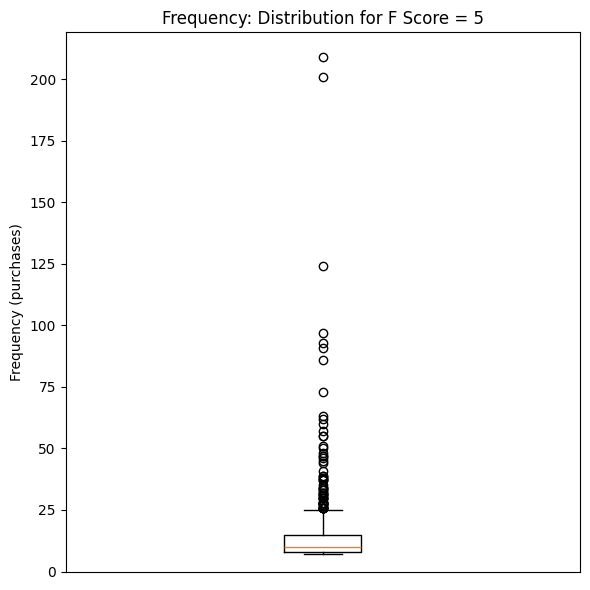

In [67]:
fig = plt.figure(figsize=(6.0, 6.0), layout="tight")
ax = fig.add_subplot()
ax.boxplot(df_rfm.loc[df_rfm.FScore == 5, "Frequency"])
ax.set_title("Frequency: Distribution for F Score = 5")
ax.set_xticks([])
ax.set_ylabel("Frequency (purchases)")
ax.set_ylim(bottom=0)
plt.show()

### Monetary value and M score
In this case, each bin has approximately the same number of customers:

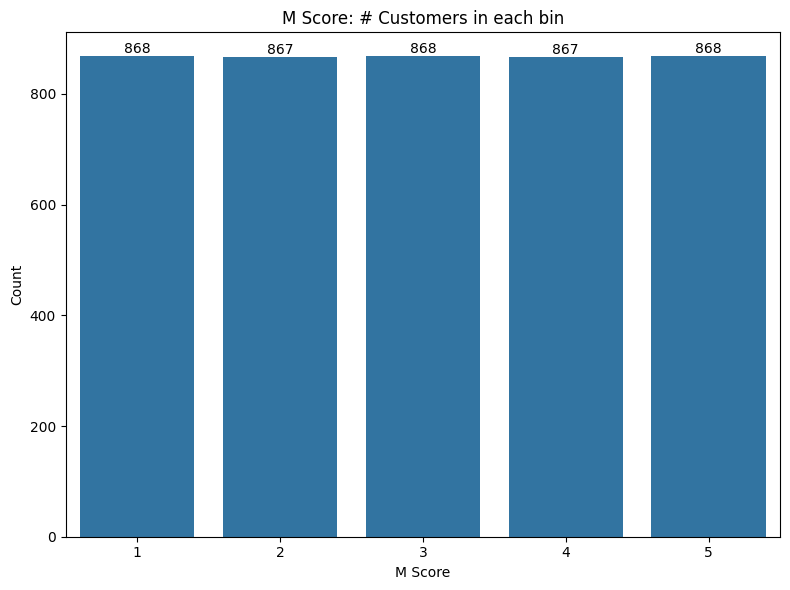

In [68]:
plot_bin_count(df_rfm, "M")

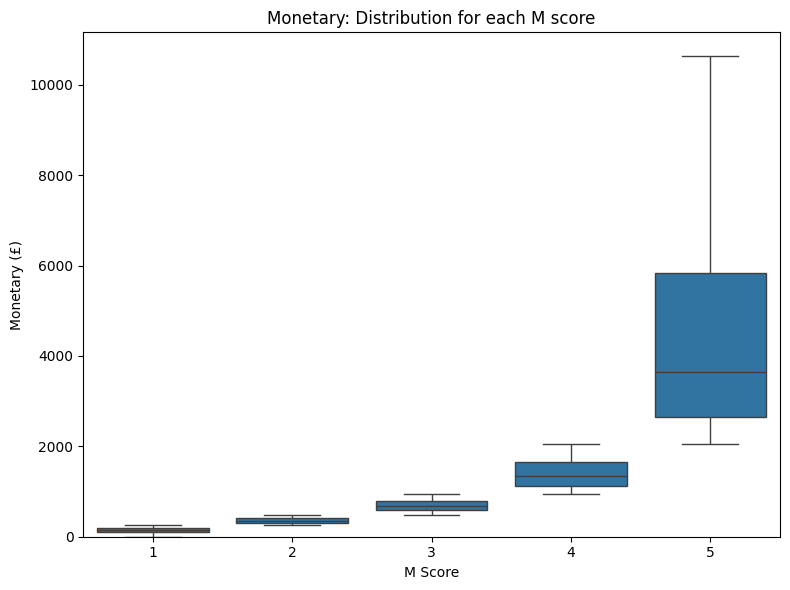

In [69]:
plot_distribution_by_score(df_rfm, "Monetary")

## Summarizing through functions
The RFM analysis isn't complete yet. But I've already achieved my goal for
this notebook. As usual, I'll conclude by writing a couple of functions that
summarize what I just did.

In [70]:
def compute_and_save_rfm_scores(
    file_path: Path,
    *,
    outlier_cols: str | list[str] | None = None,
    outlier_scale: float = 1.5,
    num_bins: int = 5,
) -> None:
    df_rfm = read_customer_data(file_path).pipe(compute_rfm_attributes)
    if outlier_cols is not None:
        df_rfm = remove_outliers(df_rfm, outlier_cols, outlier_scale)
    add_rfm_scores(df_rfm, num_bins).to_csv(file_path.parent / f"rfm_scores_{num_bins}.csv")

In [71]:
compute_and_save_rfm_scores(Path.cwd().parents[1] / "data" / "online_retail.csv")

In [72]:
def plot_rfm_attributes_and_scores(df: pd.DataFrame, figsize: tuple[float, float] = (8.0, 6.0)) -> None:
    attrs = get_args(RFMAttribute)
    for score in (attr[0] for attr in attrs):
        plot_bin_count(df, score, save=True, figsize=figsize)
    for attr in attrs:
        plot_distribution_by_score(df, attr, save=True, figsize=figsize)

In [73]:
plot_rfm_attributes_and_scores(df_rfm)